In [41]:
# missing-lt-pt05-mac-gte-2-kanpig
# https://app.terra.bio/#workspaces/allofus-drc-wgs-lr-prod/AoU_DRC_WGS_LongReads_PacBio/job_history/bde67091-255e-4181-ba82-c943c0adf2aa

run_dict = {
    'phased_snp_indel_vcf_path': 'gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/scratch/phasing_kanpig/chr1:100000000-110000000_scaffold.bcf',
    'filtered_phased_snp_indel_vcf_path': 'gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/scratch/phasing_kanpig/missing-lt-pt05-mac-gte-2-kanpig/chr1:100000000-110000000_scaffold.bcf',
    'phased_sv_vcf_path': 'gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/scratch/phasing_kanpig/missing-lt-pt05-mac-gte-2-kanpig/chr1:100000000-110000000_finalsv_scaffold.bcf',
    'preprocessed_phased_vcf': '/home/jupyter/AoU1-v1/preprocess-for-phasing/missing-lt-pt05-mac-gte-2-kanpig/pangenie-preprocess/chr1_100-110Mbp.reg_all_af_all.concat-atomize.vcf.gz',
    'panel_vcf_path': 'gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/submissions/bde67091-255e-4181-ba82-c943c0adf2aa/LeaveOneOutEvaluation/01ccadc8-3c3a-44f0-a61b-ab35aa11911d/call-PreprocessPanelVCF/AoU1-v1.chr1.c64aa5d.preprocessed.split.vcf.gz',
    'loo_panel_vcf_path': 'gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/submissions/bde67091-255e-4181-ba82-c943c0adf2aa/LeaveOneOutEvaluation/01ccadc8-3c3a-44f0-a61b-ab35aa11911d/call-CreateLeaveOneOutPanelVCF/shard-2/AoU1-v1.chr1.c64aa5d.LOO-HG03486.preprocessed.LOO.vcf.gz'
}
    

In [62]:
import argparse
import allel
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


def load_callset(callset_file, **kwargs):
    ! bcftools norm -m- -N {callset_file} -Oz -o /tmp/split_callset.vcf.gz
    return allel.read_vcf('/tmp/split_callset.vcf.gz', **kwargs)

def download_callset(callset_path, do_convert_to_vcf_gz=False):
    if do_convert_to_vcf_gz:
        ! gsutil cp {callset_path} /tmp/downloaded_callset.bcf
        ! bcftools view /tmp/downloaded_callset.bcf -Oz -o /tmp/downloaded_callset.vcf.gz
        ! bcftools index -t /tmp/downloaded_callset.vcf.gz
    else:
        ! gsutil cp {callset_path} /tmp/downloaded_callset.vcf.gz
        ! gsutil cp {callset_path}.tbi /tmp/downloaded_callset.vcf.gz.tbi
    return '/tmp/downloaded_callset.vcf.gz'

def get_gt_vsp(callset):
    return allel.GenotypeDaskArray(callset['calldata/GT'])

def plot_length_and_af_distribution(callset_vcf_gz, label, 
                                    use_context=False,
                                    vmax=10**5):
    callset = load_callset(callset_vcf_gz, fields='*', alt_number=1)
    
    is_snp_v = callset['variants/is_snp']
    num_variants = len(is_snp_v)
#     is_multiallelic_v = callset['variants/MULTIALLELIC']
    altfreq_v = callset['variants/AF']
    is_altfreq_v = [['[0%, 1%)', (0. <= altfreq_v) & (altfreq_v < 0.01)],
                    ['[1%, 5%)', (0.01 <= altfreq_v) & (altfreq_v < 0.05)],
                    ['[5%, 10%)', (0.05 <= altfreq_v) & (altfreq_v < 0.1)],
                    ['[10%, 50%)', (0.1 <= altfreq_v) & (altfreq_v < 0.50)],
                    ['[50%, 100%]', (0.5 <= altfreq_v) & (altfreq_v <= 1.)]]
    altlen_v = callset['variants/altlen']
    is_altlen_v = [['(-inf,-50]', altlen_v <= -50],
                   ['(-50,-1]', (-50 < altlen_v) & (altlen_v <= -1)],
                   ['0', altlen_v == 0],
                   ['[1,50)', (1 <= altlen_v) & (altlen_v < 50)],
                   ['[50,inf)', 50 <= altlen_v]]
    is_sv_v = (altlen_v <= -50) | (altlen_v >= 50)
    num_i = len(is_altfreq_v)
    num_j = len(is_altlen_v)

    for context in ['ALL', 'US', 'RP'] if use_context else ['ALL']:

        if context == 'ALL':
            is_context_v = True
        elif context == 'US':
            is_context_v = ~(callset[f'variants/RM'] |
                             callset[f'variants/SD'] |
                             callset[f'variants/SR'])
        else:
            is_context_v = callset[f'variants/{context}'][is_case_V]


        num_evals = np.zeros((num_i, num_j))

        for i, (filter_name_i, is_v_i) in enumerate(is_altfreq_v):
            for j, (filter_name_j, is_v_j) in enumerate(is_altlen_v):
                is_eval_v = is_v_i & is_v_j & is_context_v

                num_eval = np.sum(is_eval_v)
        
                num_evals[i][j] = num_eval
                non_sv_count = np.sum(~is_sv_v & is_context_v)
                sv_count = np.sum(is_sv_v & is_context_v)
                
        fig, ax = plt.subplots(2, 1, figsize=(12, 8))

        ax[0] = sns.heatmap(num_evals, ax=ax[0], linewidths=1, linecolor='k', annot=True,
                            norm=matplotlib.colors.LogNorm(vmax=vmax), cmap='Blues', vmax=vmax)
        cbar = ax[0].collections[0].colorbar
        cbar.ax.set_ylabel('number of alt alleles', rotation=270, labelpad=20)
        ax[0].set_title(f'{label}\ncontext = {context}\n\n' +
                        f'alt allele count\n' +
                        f'non-SV = {non_sv_count}, SV = {sv_count}, all = {num_variants}')
        ax[0].set_ylabel('AF')
        ax[0].tick_params(bottom=False, left=False)
        ax[0].set_xticklabels([])
        ax[0].set_yticklabels([filter_name for filter_name, _ in is_altfreq_v], rotation=0)
        ax[0].set_xlabel('ALT length - REF length (bp)')
        ax[0].set_xticklabels([filter_name for filter_name, _ in is_altlen_v], rotation=0)

    plt.show()

Copying gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/scratch/phasing_kanpig/chr1:100000000-110000000_scaffold.bcf...
/ [1 files][ 24.3 MiB/ 24.3 MiB]                                                
Operation completed over 1 objects/24.3 MiB.                                     
Lines   total/split/realigned/skipped:	256040/0/0/0


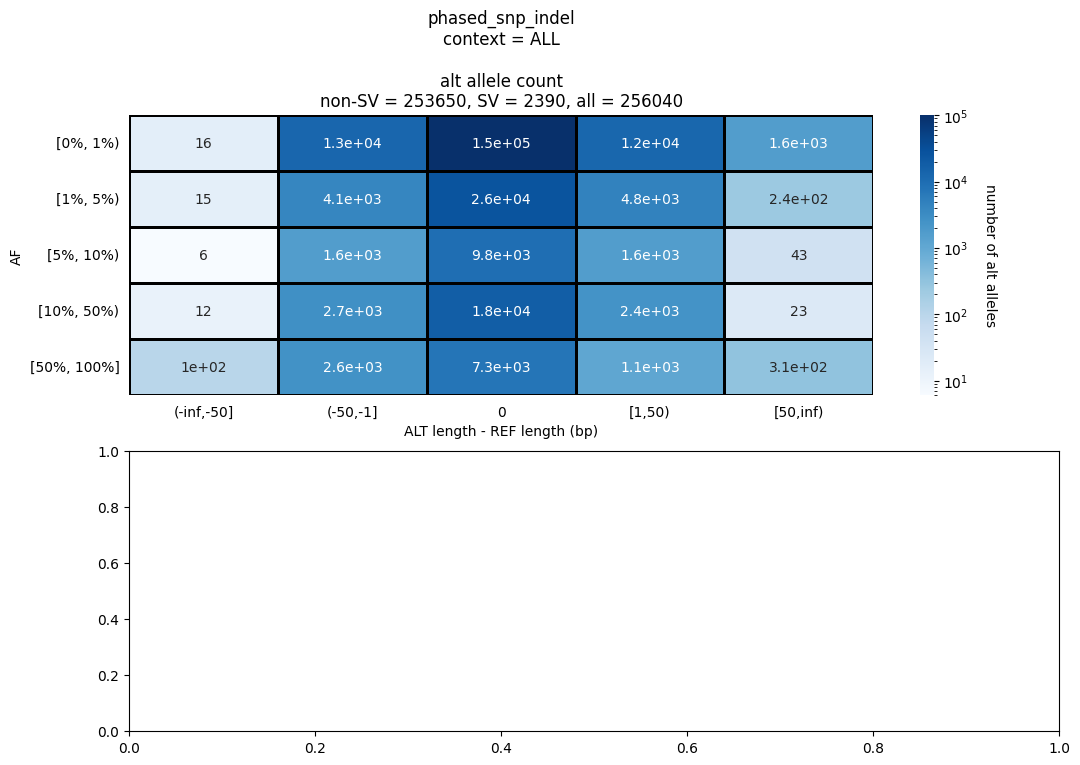

In [63]:
plot_length_and_af_distribution(download_callset(run_dict['phased_snp_indel_vcf_path'], do_convert_to_vcf_gz=True),
                                'phased_snp_indel')

Copying gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/scratch/phasing_kanpig/missing-lt-pt05-mac-gte-2-kanpig/chr1:100000000-110000000_scaffold.bcf...
- [1 files][ 14.6 MiB/ 14.6 MiB]                                                
Operation completed over 1 objects/14.6 MiB.                                     
Lines   total/split/realigned/skipped:	121659/0/0/0


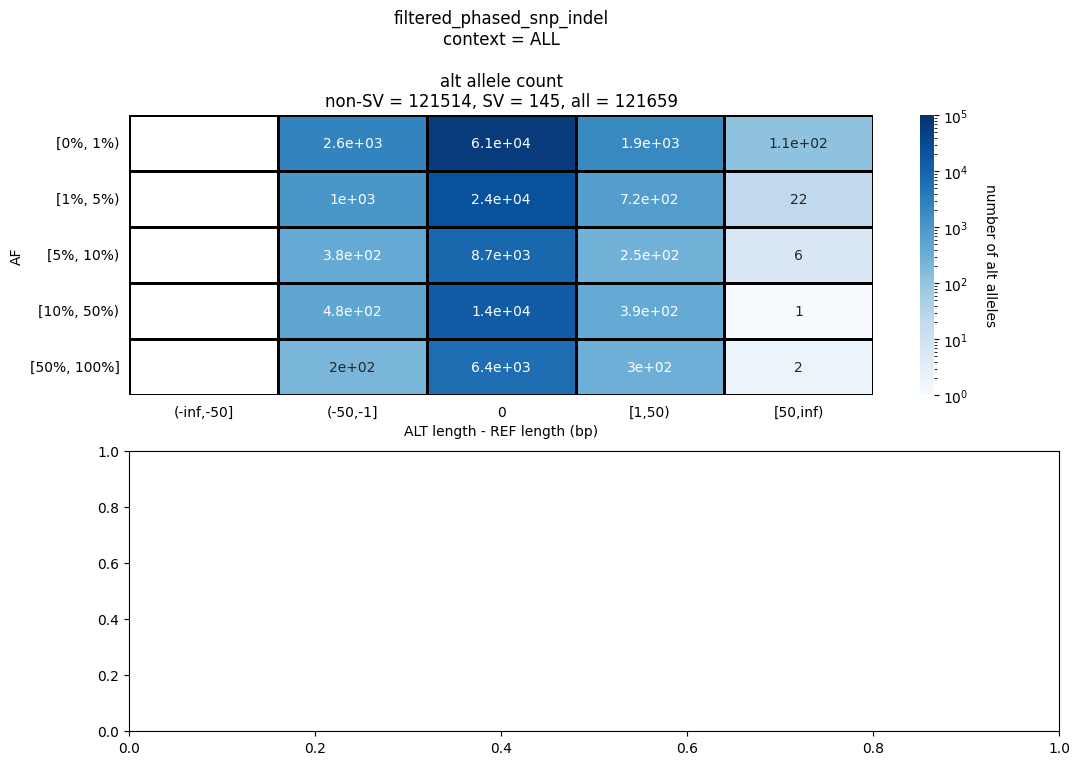

In [64]:
plot_length_and_af_distribution(download_callset(run_dict['filtered_phased_snp_indel_vcf_path'], do_convert_to_vcf_gz=True),
                                'filtered_phased_snp_indel')

Copying gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/scratch/phasing_kanpig/missing-lt-pt05-mac-gte-2-kanpig/chr1:100000000-110000000_finalsv_scaffold.bcf...
/ [1 files][367.5 KiB/367.5 KiB]                                                
Operation completed over 1 objects/367.5 KiB.                                    
Lines   total/split/realigned/skipped:	1733/0/0/0


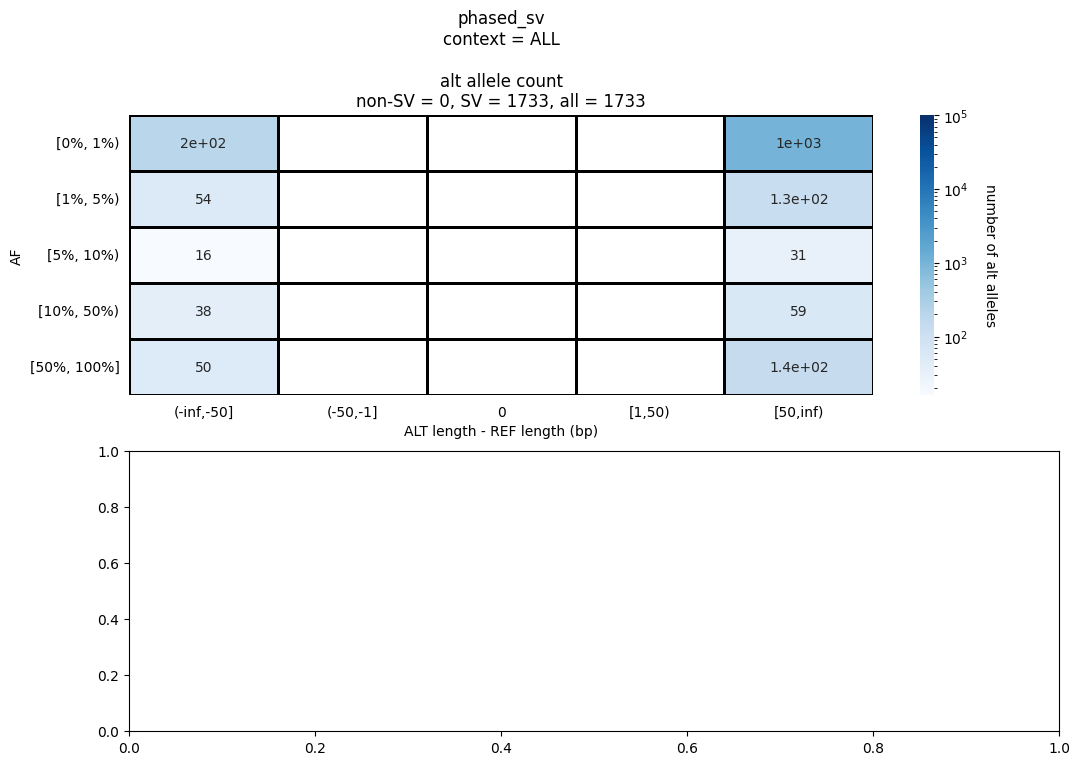

In [65]:
plot_length_and_af_distribution(download_callset(run_dict['phased_sv_vcf_path'], do_convert_to_vcf_gz=True),
                                'phased_sv')

Lines   total/split/realigned/skipped:	123269/16/0/0


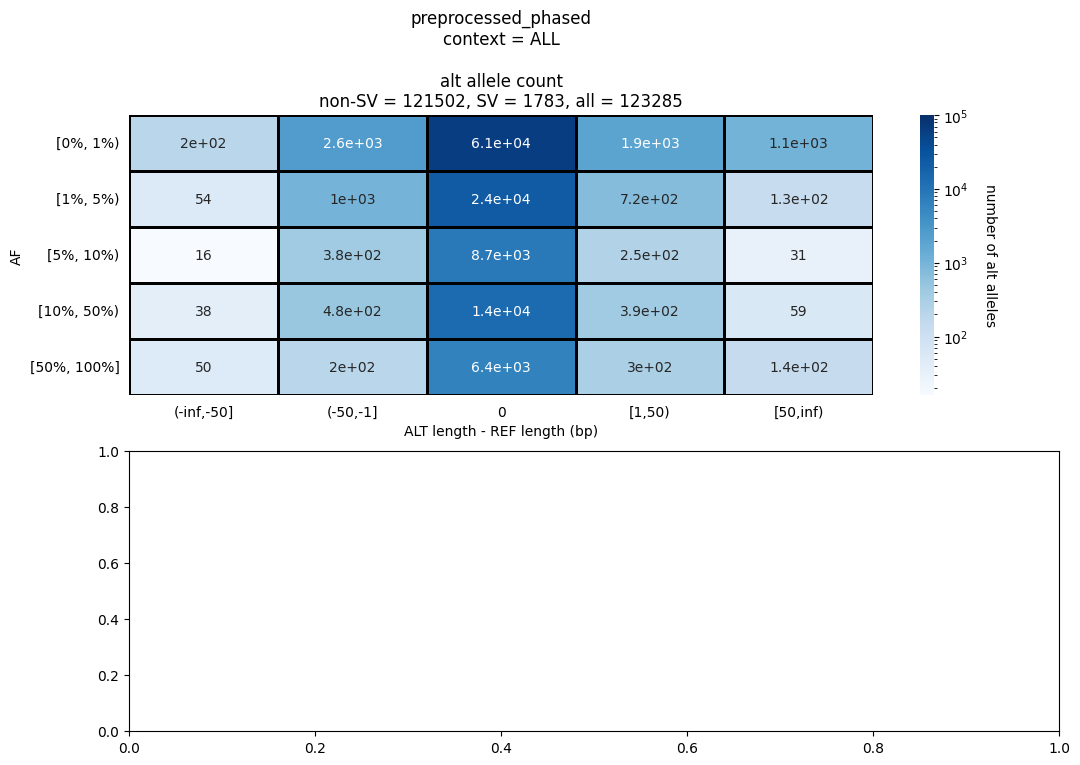

In [66]:
plot_length_and_af_distribution(run_dict['preprocessed_phased_vcf'], 
                                'preprocessed_phased')

Copying gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/submissions/bde67091-255e-4181-ba82-c943c0adf2aa/LeaveOneOutEvaluation/01ccadc8-3c3a-44f0-a61b-ab35aa11911d/call-PreprocessPanelVCF/AoU1-v1.chr1.c64aa5d.preprocessed.split.vcf.gz...
/ [1 files][ 26.5 MiB/ 26.5 MiB]                                                
Operation completed over 1 objects/26.5 MiB.                                     
Copying gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/submissions/bde67091-255e-4181-ba82-c943c0adf2aa/LeaveOneOutEvaluation/01ccadc8-3c3a-44f0-a61b-ab35aa11911d/call-PreprocessPanelVCF/AoU1-v1.chr1.c64aa5d.preprocessed.split.vcf.gz.tbi...
/ [1 files][  8.7 KiB/  8.7 KiB]                                                
Operation completed over 1 objects/8.7 KiB.                                      
Lines   total/split/realigned/skipped:	124053/0/0/0


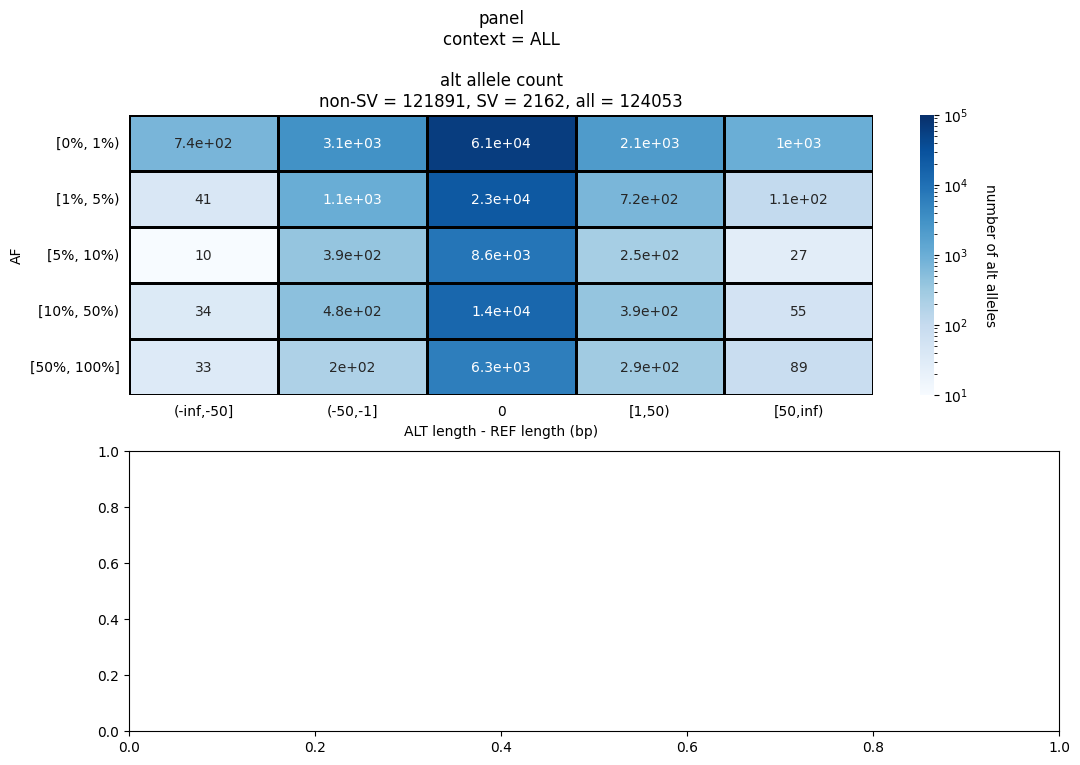

In [67]:
plot_length_and_af_distribution(download_callset(run_dict['panel_vcf_path']), 
                                'panel')

Copying gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/submissions/bde67091-255e-4181-ba82-c943c0adf2aa/LeaveOneOutEvaluation/01ccadc8-3c3a-44f0-a61b-ab35aa11911d/call-CreateLeaveOneOutPanelVCF/shard-2/AoU1-v1.chr1.c64aa5d.LOO-HG03486.preprocessed.LOO.vcf.gz...
/ [1 files][ 22.1 MiB/ 22.1 MiB]                                                
Operation completed over 1 objects/22.1 MiB.                                     
Copying gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/submissions/bde67091-255e-4181-ba82-c943c0adf2aa/LeaveOneOutEvaluation/01ccadc8-3c3a-44f0-a61b-ab35aa11911d/call-CreateLeaveOneOutPanelVCF/shard-2/AoU1-v1.chr1.c64aa5d.LOO-HG03486.preprocessed.LOO.vcf.gz.tbi...
/ [1 files][  8.7 KiB/  8.7 KiB]                                                
Operation completed over 1 objects/8.7 KiB.                                      
Lines   total/split/realigned/skipped:	117975/1668/0/0


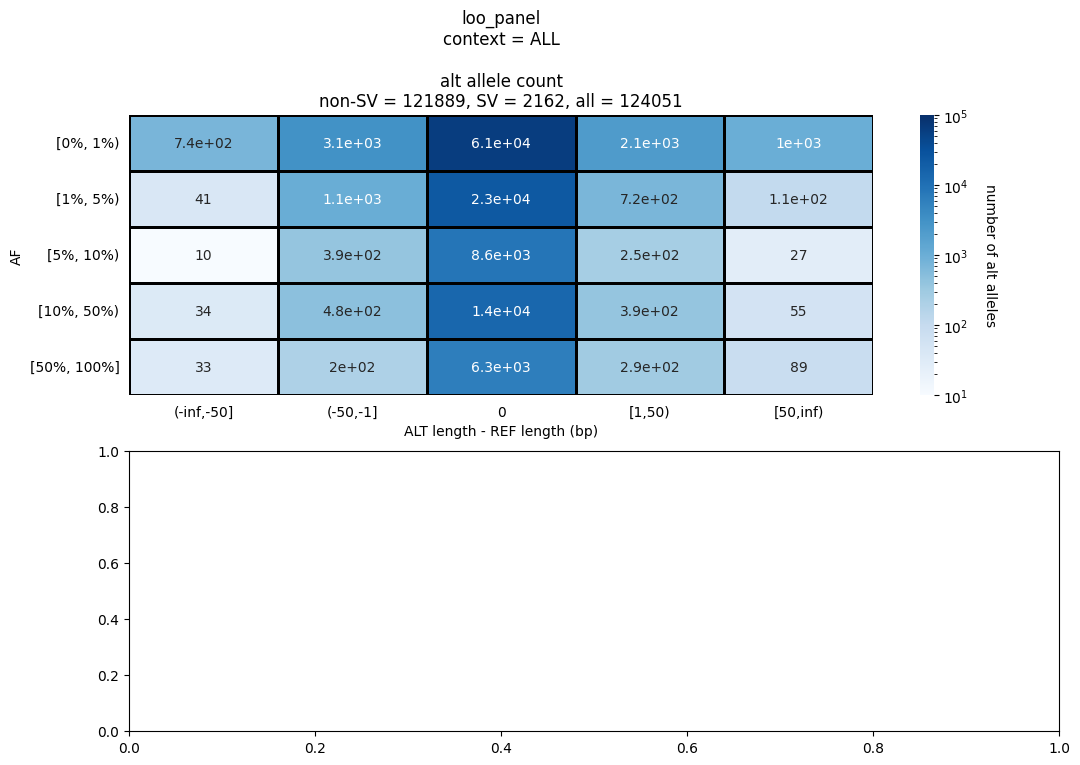

In [68]:
plot_length_and_af_distribution(download_callset(run_dict['loo_panel_vcf_path']), 
                                'loo_panel')